In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
confusion_matrix,
accuracy_score,
precision_score,
recall_score, 
f1_score,
matthews_corrcoef,
cohen_kappa_score,
roc_auc_score, 
roc_curve,
mean_squared_error,
mean_absolute_percentage_error
)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the Dataset
data = pd.read_csv(r"D:\CS6501\PROJECT WORKS\Final Dataset-v.1\Dataset_2.csv")
print("Dataset Loaded:")
print(data.head())

Dataset Loaded:
   id        V1        V2        V3        V4        V5        V6        V7  \
0   0 -0.260648 -0.469648  2.496266 -0.083724  0.129681  0.732898  0.519014   
1   1  0.985100 -0.356045  0.558056 -0.429654  0.277140  0.428605  0.406466   
2   2 -0.260272 -0.949385  1.728538 -0.457986  0.074062  1.419481  0.743511   
3   3 -0.152152 -0.508959  1.746840 -1.090178  0.249486  1.143312  0.518269   
4   4 -0.206820 -0.165280  1.527053 -0.448293  0.106125  0.530549  0.658849   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0 -0.130006  0.727159  ... -0.110552  0.217606 -0.134794  0.165959  0.126280   
1 -0.133118  0.347452  ... -0.194936 -0.605761  0.079469 -0.577395  0.190090   
2 -0.095576 -0.261297  ... -0.005020  0.702906  0.945045 -1.154666 -0.605564   
3 -0.065130 -0.205698  ... -0.146927 -0.038212 -0.214048 -1.893131  1.003963   
4 -0.212660  1.049921  ... -0.106984  0.729727 -0.161666  0.312561 -0.414116   

        V26       V27       

In [3]:
# Dataset Overview
print("\nDataset Summary:")
print(data.describe())  # Statistical summary of the dataset
print("\nDataset Info:")
print(data.info())  # Dataset information


Dataset Summary:
                  id            V1            V2            V3            V4  \
count  568630.000000  5.686300e+05  5.686300e+05  5.686300e+05  5.686300e+05   
mean   284314.500000  2.076882e-12 -3.248204e-12 -3.636929e-12  3.879536e-12   
std    164149.486121  1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00   
min         0.000000 -3.495584e+00 -4.996657e+01 -3.183760e+00 -4.951222e+00   
25%    142157.250000 -5.652859e-01 -4.866777e-01 -6.492987e-01 -6.560203e-01   
50%    284314.500000 -9.363846e-02 -1.358939e-01  3.528580e-04 -7.376152e-02   
75%    426471.750000  8.326582e-01  3.435552e-01  6.285380e-01  7.070047e-01   
max    568629.000000  2.229046e+00  4.361865e+00  1.412583e+01  3.201536e+00   

                 V5            V6            V7            V8            V9  \
count  5.686300e+05  5.686300e+05  5.686300e+05  5.686300e+05  5.686300e+05   
mean   2.409066e-13  2.768028e-12 -9.496329e-14  2.831363e-12 -2.488498e-12   
std    1.000001e+00  1.0

In [4]:
# Remove Duplicate Rows
data = data.drop_duplicates()
print(f"\nDataset shape after removing duplicates: {data.shape}")


Dataset shape after removing duplicates: (568630, 31)


In [5]:
# Handle Missing Values
data.fillna(data.mean(), inplace=True)
print("Missing values handled.")

Missing values handled.


In [6]:
# Remove outliers
def remove_outliers(data):
    for col in data.select_dtypes(include=['number']).columns:
        if col != 'Class':  # Do not remove rows affecting the target variable
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            data = data[(data[col] >= lower_bound) | (data['Class'] == 1)]
    return data

# Apply the outlier removal function
data_cleaned = remove_outliers(data)
print(f"Cleaned Dataset Class Distribution:")
print(data_cleaned['Class'].value_counts())

Cleaned Dataset Class Distribution:
Class
1    284315
0    247529
Name: count, dtype: int64


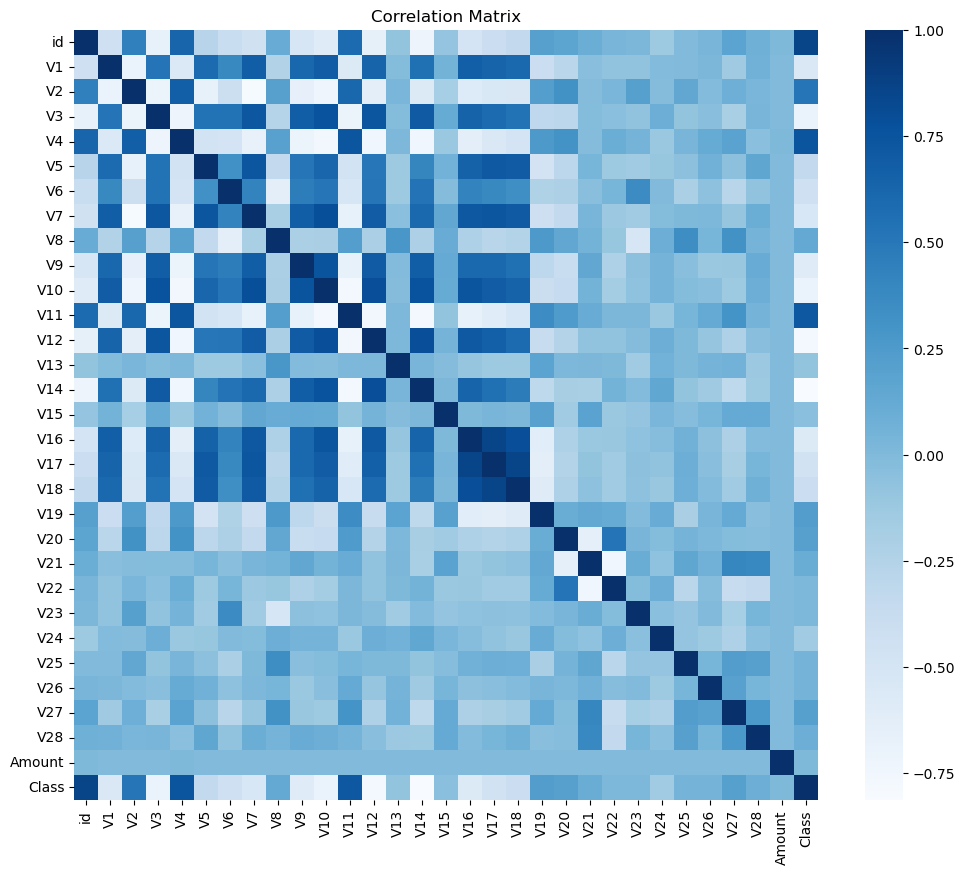

In [7]:
# Display Correlation Matrix
corr_matrix = data_cleaned.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='Blues', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

In [8]:
# Remove Highly Correlated Features
correlation_threshold = 0.9
correlated_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > correlation_threshold:
            correlated_features.add(corr_matrix.columns[i])

data_cleaned = data_cleaned.drop(columns=correlated_features)
print(f"\nRemoved highly correlated features: {correlated_features}")
print(f"Dataset shape after removing correlated features: {data_cleaned.shape}")


Removed highly correlated features: set()
Dataset shape after removing correlated features: (531844, 31)


In [9]:
# Separate Features and Target
X = data_cleaned.drop('Class', axis=1)
y = data_cleaned['Class']
print("Features and target separated.")

Features and target separated.


In [10]:
# Handle Class Imbalance using SMOTE
print("\nOriginal Class Distribution:")
print(y.value_counts())


Original Class Distribution:
Class
1    284315
0    247529
Name: count, dtype: int64


In [11]:
# Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\nTrain-test split completed.")


Train-test split completed.


In [12]:
#Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# Train and evaluate SVM with Linear Kernel
print("\nTraining SVM with Linear Kernel...")
svm_linear = SVC(kernel='linear', probability=True, random_state=42)
svm_linear.fit(X_train_scaled, y_train)
y_pred_linear = svm_linear.predict(X_test_scaled)
y_prob_linear = svm_linear.predict_proba(X_test_scaled)[:, 1]


Training SVM with Linear Kernel...


In [14]:
# Train and evaluate SVM with RBF Kernel
print("\nTraining SVM with RBF Kernel...")
svm_rbf = SVC(kernel='rbf', probability=True, random_state=42)
svm_rbf.fit(X_train_scaled, y_train)
y_pred_rbf = svm_rbf.predict(X_test_scaled)
y_prob_rbf = svm_rbf.predict_proba(X_test_scaled)[:, 1]


Training SVM with RBF Kernel...


In [27]:
def evaluate_model(y_true, y_pred, y_prob=None):
    # Print metrics
    print("\nConfusion Matrix:")
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(conf_matrix)
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")
    print(f"MCC: {matthews_corrcoef(y_true, y_pred):.4f}")
    print(f"Cohen Kappa: {cohen_kappa_score(y_true, y_pred):.4f}")
    print(f"Mean Squared Error: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_true, y_pred):.4f}")
    
    # Confusion matrix visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix Heatmap')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    # ROC-AUC curve if probabilities or decision scores are provided
    if y_prob is not None:
        print(f"ROC-AUC: {roc_auc_score(y_true, y_prob):.4f}")
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        
        # Plot the ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color="blue", label="ROC Curve (AUC = %.4f)" % roc_auc_score(y_true, y_prob))
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")  # Baseline
        plt.xlabel("False Positive Rate (FPR)")
        plt.ylabel("True Positive Rate (TPR)")
        plt.title("Receiver Operating Characteristic (ROC) Curve")
        plt.legend(loc="lower right")
        plt.grid()  # Add gridlines
        plt.show()


Evaluation for SVM with Linear Kernel:

Confusion Matrix:
[[49471    35]
 [   82 56781]]
Accuracy: 0.9989
Precision: 0.9994
Recall: 0.9986
F1-Score: 0.9990
MCC: 0.9978
Cohen Kappa: 0.9978
Mean Squared Error: 0.0011
Mean Absolute Percentage Error: 1481878996305.0083


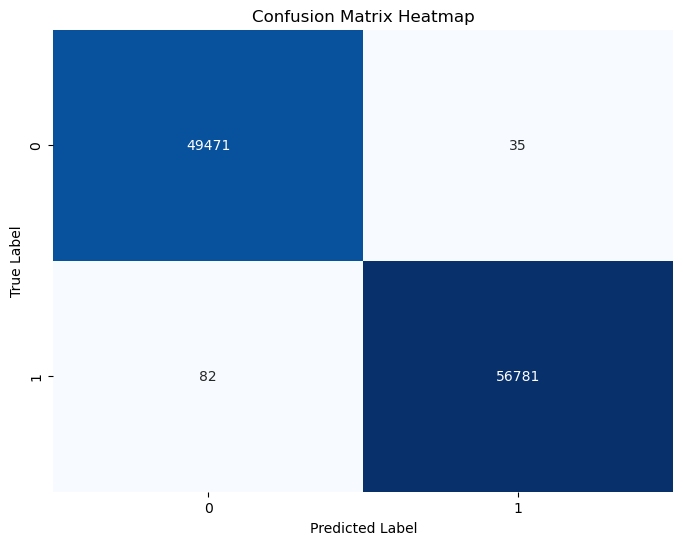

ROC-AUC: 0.9999


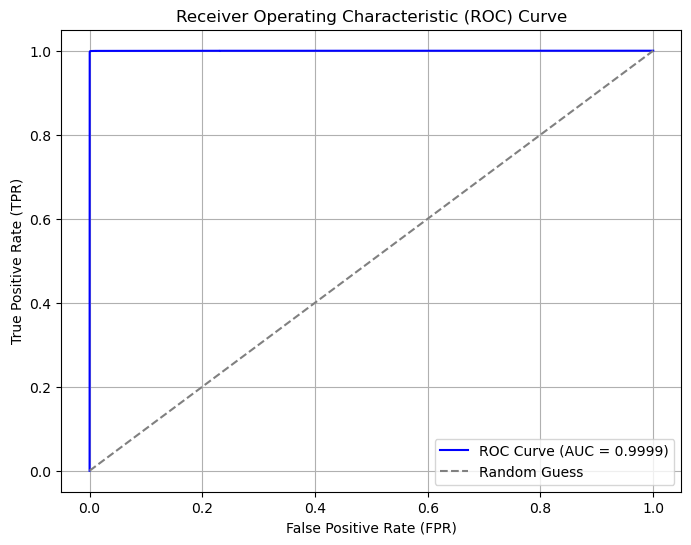

In [28]:
# Call the evaluation function for linear
print("\nEvaluation for SVM with Linear Kernel:")
evaluate_model(y_test, y_pred_linear, y_prob_linear)


Evaluation for SVM with RBF Kernel:

Confusion Matrix:
[[49496    10]
 [   22 56841]]
Accuracy: 0.9997
Precision: 0.9998
Recall: 0.9996
F1-Score: 0.9997
MCC: 0.9994
Cohen Kappa: 0.9994
Mean Squared Error: 0.0003
Mean Absolute Percentage Error: 423393998944.2880


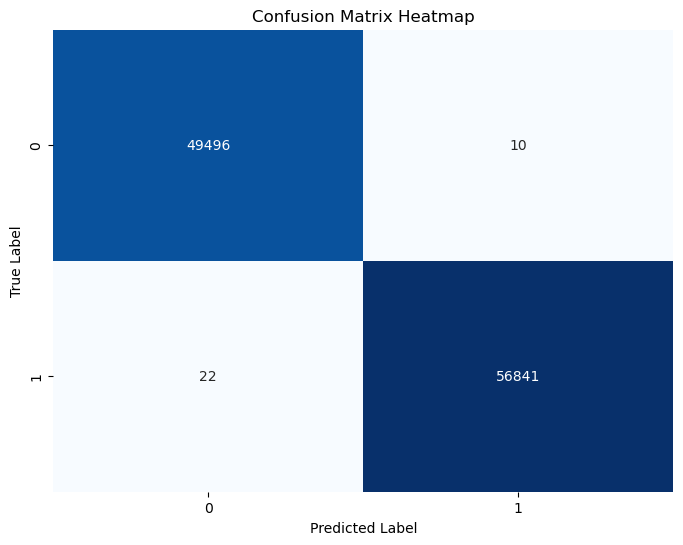

ROC-AUC: 1.0000


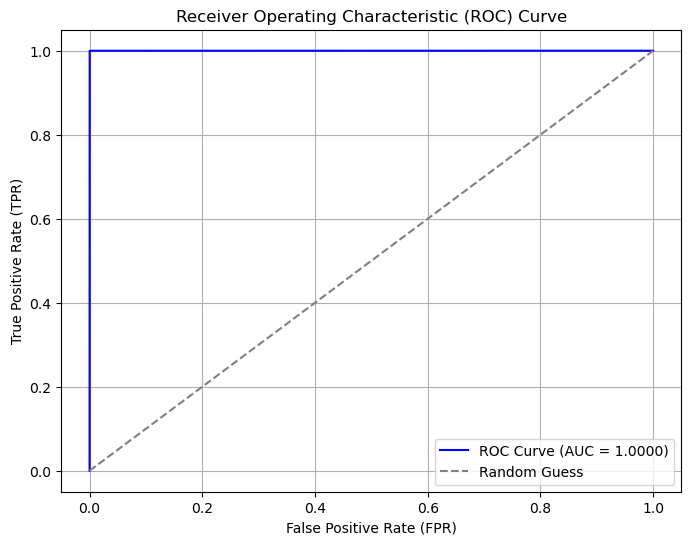

In [30]:
# Call the evaluation function for RBF
print("\nEvaluation for SVM with RBF Kernel:")
evaluate_model(y_test, y_pred_rbf, y_prob_rbf)